In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_colwidth=300

In [3]:
# Shingle generators 
# Arguments : Message string, shingle size {in words}
# Returns : All shingles formed with k words
def shingle_generator(message, k):
    message = message.split(' ')
    item_set = []
    for i in range(0, len(message)-k):
        shingle =  ""
        for j in range(0, k):
            shingle = shingle + message[i+j] + " "
        item_set.append(shingle)
    return item_set

In [4]:
def jaccard_similarity(str1, str2):
    string_set1 = set(str1.split(' '))
    string_set2 = set(str2.split(' '))
    return len(string_set1.intersection(string_set2))/len(string_set2.union(string_set1))

In [5]:
# dump pkl into a pandas dataframe. 
data = pd.read_pickle('data/string_study.pkl')

In [6]:
data["word_count"] = data._info.apply(lambda x:len(x.split(' ')))
# data.head(7)

In [7]:
msg_array = np.array(data._info.copy())
# msg_array

In [8]:
class_by_len_set = set(data.word_count)

In [9]:
# class_by_len_set

In [10]:
# Taking the smallest one to test minhash algo
len(data.query("word_count == 21"))

47

In [11]:
filtered_data = data.query("word_count == 21")
# filtered_data.head(47)

In [12]:
set(np.array(filtered_data.msg))

{'Build of instance xyz aborted: Service Unavailable (HTTP 503)',
 'Connection to the hypervisor is broken on host: xyz.cern.ch',
 'Script execution failed: Error running command {"interpreter": "/bin/sh", "script_inline": "ping -c ',
 'The server is currently unavailable. Please try again at a later time.<br /><br />    (HTTP 503) (Re',
 'Unable to establish connection to https:some_url (\\\'Connection aborted.\\\', BadStatusLine("\\\'\\\'",))'}

In [13]:
msg_array = np.array(filtered_data._info.copy())
jaccard_sim_set = []
jaccard_matrix = [[0 for i in range(len(msg_array))] for j in range(len(msg_array))]
for i in range(0, len(msg_array)):
    jaccard_matrix[i][i] = 1
    for j in range(i+1, len(msg_array)):
        jaccard_sim = jaccard_similarity(msg_array[i], msg_array[j])
        jaccard_sim_set.append(jaccard_sim)
        jaccard_matrix[i][j] = jaccard_sim
        jaccard_matrix[j][i] = jaccard_sim
set(jaccard_sim_set)

{0.0,
 0.02564102564102564,
 0.027777777777777776,
 0.3125,
 0.3225806451612903,
 0.36666666666666664,
 0.7391304347826086,
 0.75,
 0.8181818181818182,
 1.0}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120064320>]],
      dtype=object)

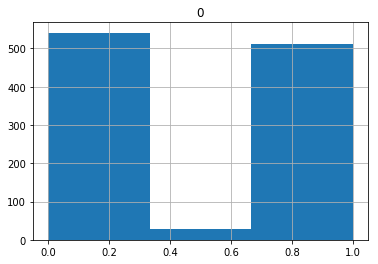

In [14]:
jaccard_dataframe = pd.DataFrame(jaccard_sim_set)
jaccard_dataframe.hist(bins = 3)

In [15]:
raw_msgs = filtered_data._info

In [16]:
# raw_msgs

In [17]:
# raw_msgs = pd.DataFrame(raw_msgs, columns=["_info"])

In [18]:
# Generate the set of words of all raw messages
message_set = []
# %time

for item in np.array(raw_msgs):
#     print(item)
    item = str(item)
    set_of_words = set(item.split(' '))
    # Shingle size is set to 3 words
    set_of_words = set(shingle_generator(item, 2))
    message_set.append(set_of_words)


In [19]:
import numpy as np
import csv
import pandas
from datasketch import MinHash, MinHashLSH

In [20]:
# Generate MinHash instances for all messages
m = []
for i in range (0, len(message_set)):
    m_temp = MinHash(num_perm=128)
    m.append(m_temp)
len(m)

47

In [23]:
i = 0
for message in message_set:
    for word in message:
        m[i].update(word.encode('utf-8'))
    i = i + 1

In [24]:
# Create an LSH indexb
# %time
lsh = MinHashLSH(threshold=.35, num_perm=128)
count = 0
for i in range (0, len(m)):
    string = "m" + str(i)
    lsh.insert(string, m[i])
    count += 1
print (count)

47


In [25]:
# Find all the messages similar to the fist message with a specified threshold
%time
result = lsh.query(m[0])
# (result)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


In [26]:
# Repeat the clustering proc for every message. 
clusters = {}
cluster_count = 1
# For every message add the result to the cluster
for i in range(0, len(m)):
    # check if the message belongs to any cluster
    msg_str = "m" + str(i)
    flag = 1
    for item in clusters.values():
        if msg_str in item:
            flag = 0
            break
    # End of check box
    if flag:
        result = lsh.query(m[i])
        clusters[cluster_count] = result
        cluster_count += 1

In [27]:
clusters

{1: ['m2',
  'm8',
  'm22',
  'm0',
  'm14',
  'm17',
  'm7',
  'm15',
  'm13',
  'm27',
  'm19',
  'm21',
  'm29',
  'm6',
  'm25',
  'm9',
  'm11',
  'm3',
  'm12',
  'm4',
  'm18',
  'm5',
  'm26',
  'm20',
  'm10',
  'm16',
  'm24',
  'm23',
  'm28'],
 2: ['m1'],
 3: ['m30',
  'm36',
  'm37',
  'm39',
  'm31',
  'm42',
  'm32',
  'm34',
  'm43',
  'm41',
  'm35',
  'm40',
  'm33',
  'm44',
  'm38'],
 4: ['m45'],
 5: ['m2',
  'm8',
  'm22',
  'm46',
  'm14',
  'm17',
  'm7',
  'm15',
  'm13',
  'm27',
  'm21',
  'm29',
  'm6',
  'm25',
  'm9',
  'm11',
  'm3',
  'm12',
  'm4',
  'm5',
  'm18',
  'm26',
  'm20',
  'm10',
  'm16',
  'm24',
  'm23',
  'm28']}